In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import os.path
from os.path import join
import numpy as np
import imodelsx
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import data
import joblib
import dvu
files_dict = data.load_files_dict_single_site()

[2024-01-18 18:25:15,519] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


success: 18
fail: ['Cincinnati', 'Columbus']


/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### Filter data for single-site analysis

In [26]:
# checkpoint = 'meta-llama/Llama-2-7b-hf'
checkpoint = 'gpt-4'  # gpt-35-turbo
site = 'Atlanta'
# site = 'Columbus'
# site = 'WashingtonDC'
df = files_dict[site]

qs, responses_df, themes_df = data.split_single_site_df(df)

In [27]:
question, responses, theme_dict = data.get_data_for_question_single_site(
    question_num=8, qs=qs, responses_df=responses_df, themes_df=themes_df)

In [28]:
def numbered_list(classes):
    # return '\n'.join([f'Class {i+1}. {c}' for i, c in enumerate(classes)])
    return '\n'.join([f'{i+1}. {c}' for i, c in enumerate(classes)])


classification_prompt = '''### You are given a question, response, and a numbered list of themes below.

Question: {question}

Response: {response}

Themes:
{classes_as_numbered_list}

### Which of the themes does the response above belong to? Return the theme number.

Answer:'''
llm = imodelsx.llm.get_llm(checkpoint, repeat_delay=3)

In [29]:
response = responses[1]
if len(theme_dict) > 1:
    assert not pd.isna(response)
    prompt = classification_prompt.format(
        question=question,
        classes_as_numbered_list=numbered_list(theme_dict.keys()),
        response=response,
    )
    print(prompt)
# llm(prompt)

### You are given a question, response, and a numbered list of themes below.

Question: Would you want somebody else to decide if your child could be a research subject?  If so, who?

Response: "I feel like the paramedics would have the best intentions for my child. I would have to trust their medical background in their knowledge."

Themes:
1. Yes, trust paramedic medical judgement
2. No
3. Yes
4. No; decision should be made by parent
5. Yes, family member or close friend
6. No; noobody should be asked to make that decision
7. Answer not recorded

### Which of the themes does the response above belong to? Return the theme number.

Answer:


In [30]:
# screen valid questions
valid_question_nums = []
for question_num in tqdm(range(len(qs)), position=0):

    question, responses, theme_dict = data.get_data_for_question_single_site(
        question_num=question_num, qs=qs, responses_df=responses_df, themes_df=themes_df)

    # print(theme_dict)
    # valid only if there are multiple themes
    if len(theme_dict) > 1:

        # valid only if the number of theme values == number of non-null responses
        if sum(theme_dict.values()) == sum(responses.notna()):
            valid_question_nums.append(question_num)
        # assert sum(theme_dict.values()) == sum(responses.notna(
        # )), f'{sum(theme_dict.values())} != {sum(responses.notna())}, theme_dict: {theme_dict}, responses: {responses}\nquestion {question_num}: {question}'
print('num valid qs', len(valid_question_nums))

100%|██████████| 46/46 [00:00<00:00, 2170.67it/s]

num valid qs 8


### Run classification
Note: this uses a lot of calls, num valid questions * num responses = 250

In [31]:
classifications = defaultdict(list)
for question_num in tqdm(valid_question_nums, position=0):

    question, responses, theme_dict = data.get_data_for_question_single_site(
        question_num=question_num, qs=qs, responses_df=responses_df, themes_df=themes_df)

    for response_num in tqdm(range(len(responses)), position=1):
        response = responses.values[response_num]

        if not pd.isna(response):
            prompt = classification_prompt.format(
                question=question,
                classes_as_numbered_list=numbered_list(theme_dict.keys()),
                response=response,
            )
            ans = llm(prompt)
            classifications[question_num].append(ans)

100%|██████████| 11/11 [00:00<00:00, 4455.13it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5125.80it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5518.16it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 4936.59it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5443.93it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5259.62it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 11/11 [00:00<00:00, 5296.45it/s]


cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


100%|██████████| 8/8 [00:00<00:00, 140.92it/s]

cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!
cached!


### Compare acc

In [32]:
def process_classifications(x):
    # note, only works with <10 classes
    for i in range(1, 10):
        if x.startswith(str(i)):
            return i
    else:
        return 1


diffs = []
class_count_pred = []
class_count_gt = []
for question_num in valid_question_nums:
    question, responses, theme_dict = data.get_data_for_question_single_site(
        question_num=question_num, qs=qs, responses_df=responses_df, themes_df=themes_df)

    answer_counts = theme_dict.values()
    class_counts = pd.Series(classifications[question_num]).apply(
        process_classifications).value_counts()

    # convert value_counts to dict
    answer_counts_dict = {i + 1: round(v)
                          for i, v in enumerate(theme_dict.values())}
    class_counts_dict = {k: round(v) for k, v in class_counts.items()}
    for i in answer_counts_dict.keys():
        if i not in class_counts_dict:
            class_counts_dict[i] = 0

    # print(answer_counts_dict)
    # print(class_counts_dict)
    # print()

    class_count_pred += list(class_counts_dict.values())
    class_count_gt += list(answer_counts_dict.values())

    diffs.append(np.sum(np.abs(np.array(list(answer_counts_dict.values())) -
                               np.array(list(class_counts_dict.values())))))

n = max(class_count_gt + class_count_pred)
mat = np.zeros((n, n))
for i, j in zip(class_count_pred, class_count_gt):
    mat[i - 1, j - 1] += 1
joblib.dump(mat, join(data.PROCESSED_DIR,
            f'classification_confusion_matrix_{site}_{checkpoint}.pkl'))

['/home/chansingh/pedidose-efic-analysis/processed/classification_confusion_matrix_WashingtonDC_gpt-35-turbo.pkl']

### Make plot

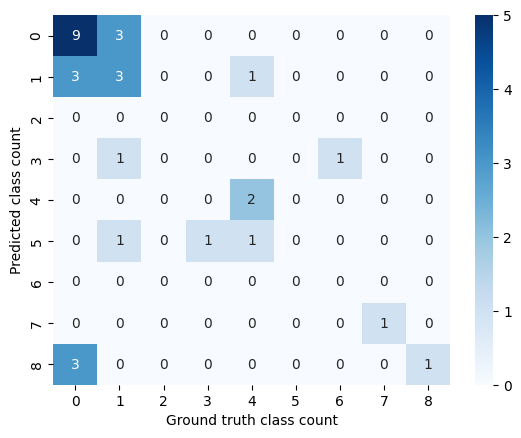

In [33]:
# differences
# plt.hist(diffs)

# Counts as scatter plot
# plt.plot(class_count_gt, class_count_pred, 'o', alpha=0.05)
# plt.xlabel('Ground Truth Class Count')
# plt.ylabel('Predicted Class Count')


sns.heatmap(mat, annot=True, fmt='g', vmax=5, cmap='Blues')
plt.ylabel('Predicted class count')
plt.xlabel('Ground truth class count')

plt.savefig(
    f'../figs/eda/classification_heatmap_{site}_{checkpoint}.pdf', bbox_inches='tight')
plt.show()

### Make aggregated heatmap

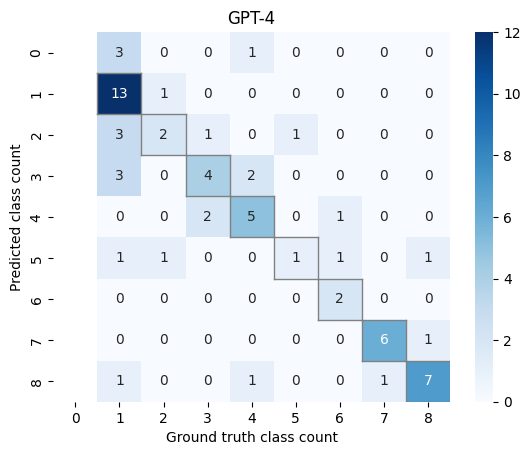

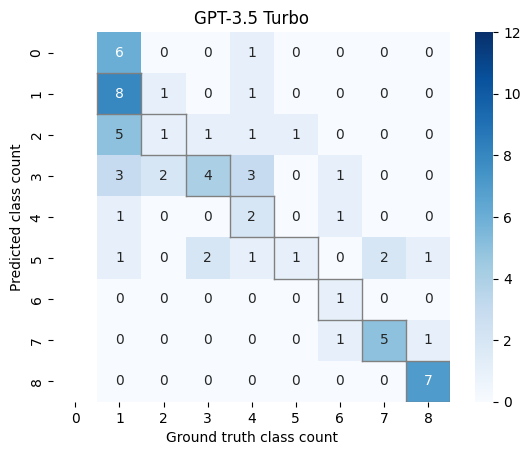

In [44]:
sites = ['Atlanta', 'Columbus', 'WashingtonDC']
checkpoints = ['gpt-4', 'gpt-35-turbo']
vmax = 12

# fig, axes = plt.subplots(1, len(checkpoints), figsize=(len(checkpoints) * 5, 5))
for i, checkpoint in enumerate(checkpoints):
    mat = None
    for site in sites:
        mat_new = joblib.load(join(data.PROCESSED_DIR,
                                   f'classification_confusion_matrix_{site}_{checkpoint}.pkl'))

        # sum mat_new with mat, make size bigger if needed
        if mat is None:
            mat = mat_new
        else:
            if mat.shape[0] < mat_new.shape[0]:
                mat = np.pad(
                    mat, ((0, mat_new.shape[0] - mat.shape[0]), (0, 0)))
            if mat.shape[1] < mat_new.shape[1]:
                mat = np.pad(
                    mat, ((0, 0), (0, mat_new.shape[1] - mat.shape[1])))
            mat += mat_new
    mat[:, 0] = np.nan

    sns.heatmap(mat, annot=True, fmt='g', cmap='Blues', vmax=vmax)
    # plt.xticks(np.arange(mat.shape[1]) + 0.5, np.arange(np.max(mat.shape[1])) + 1)
    dvu.outline_diagonal(mat.shape, roffset=0.5, coffset=0.5, skip_rows=[0])
    plt.ylabel('Predicted class count')
    plt.xlabel('Ground truth class count')
    plt.title(data.RENAME_CHECKPOINTS_DICT.get(checkpoint, checkpoint))
    plt.savefig(
        f'../figs/classification_heatmap_{checkpoint}.pdf', bbox_inches='tight')
    plt.savefig(
        f'../figs/classification_heatmap_{checkpoint}.png', bbox_inches='tight', dpi=300)
    plt.show()